In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Covid Modeling

Warning: I have no idea what I'm doing. Don't take these numbers seriously.

Cases is an array with one element for each member of the population. It's 0 if that person is not infected. A new infection gets a random integer that counts down the number of days 'til recovery. We subtract one each day from all non-zero values until they reach zero.

The array `pop` represents immunity in the population as a probability of getting infected if exposed. 0.0 means that person will certainly get sick if exposed. 1.0 means bomb-proof immunity.

Non-vector version, maybe a little more readable.

In [17]:
def spread(cases, pop, n, r0=15):
    mu = 0
    sigma = 1
    new_cases = (sum(cases > 0) * r0/10* np.random.lognormal(mu, sigma) / np.exp(mu + sigma**2/2)).round().astype(int)
    for exposure in np.random.choice(n, new_cases, replace=True):
        # if you're already infected, nothing happens
        if cases[exposure] == 0 and pop[exposure] < np.random.uniform(0,1):
            cases[exposure] = (np.random.beta(3,2,1)*10).astype(int)
            pop[exposure] = min(1.0, pop[exposure] + (1-pop[exposure])*np.random.normal(0.6, 0.2))

    return cases

Vectorized spread function. Disappointingly, it's not that much faster than the previous version.

In [93]:
def spread(cases, pop, n, r0=15):
    mu = 0
    sigma = 1

    # how many new exposures result from the existing cases?
    exposures = (sum(cases > 0) * r0/10 * np.random.lognormal(mu, sigma) / np.exp(mu + sigma**2/2)).round().astype(int)

    # randomly sample from the population to decide who gets exposed
    exposure_indexes = np.unique(np.random.choice(n, exposures, replace=True))

    # If an existing case is exposed, nothing happens. Otherwise, an exposure
    # turns into a case if their immunity fails to stop infection
    case_indexes = exposure_indexes[ (cases[exposure_indexes] == 0) & (pop[exposure_indexes] < np.random.uniform(0,1,exposure_indexes.shape)) ]

    # Draw how many days each case will be sick from a beta distribution
    # Note: maybe should depend on immunity?
    cases[case_indexes] = (np.random.beta(3,2,case_indexes.shape)*10).astype(int)

    # being infected causes immunity to increase. Should being exposed also?
    pop[case_indexes] = (pop[case_indexes] + (1-pop[case_indexes])*np.random.normal(0.6, 0.2, case_indexes.shape)).clip(0.0, 1.0)

    return cases, pop

In [94]:
def recover(cases, pop, waning_immunity=1.0):
    cases[cases>0] -= 1
    return cases, pop * waning_immunity

## Try in small population

100%|██████████| 365/365 [00:18<00:00, 19.39it/s]


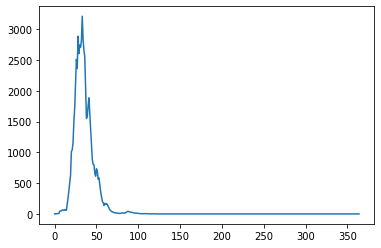

In [96]:
n=10000
cases = np.zeros(n)
cases[0] = 10
pop = np.random.uniform(0,1,n)

n_cases = []
for i in tqdm(range(365)):
    cases, pop = spread(cases, pop, n=n, r0=15)
    cases, pop = recover(cases, pop, waning_immunity=0.999)
    n_cases.append(sum(cases>0))

plt.plot(n_cases)
plt.show()

In [87]:
n=10000

runs = []
for j in tqdm(range(100)):
    cases = np.zeros(n)
    cases[0] = 10
    pop = np.random.uniform(0,1,n)

    n_cases = []
    for i in range(365):
        cases = spread(cases, pop, n=n, r0=8)
        cases, pop = recover(cases, pop, waning_immunity=0.999)
        n_cases.append(sum(cases>0))

    runs.append(n_cases)

 31%|███       | 31/100 [09:21<20:44, 18.04s/it]

(100, 365)
(365,)


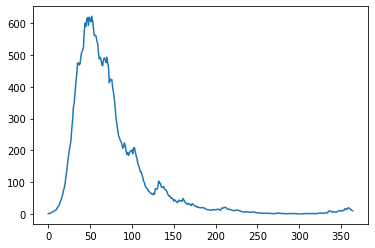

In [97]:
z = np.stack(runs, axis=0)
print(z.shape)
z = z.mean(axis=0)
print(z.shape)
plt.plot(z)
plt.show()

In [100]:
import seaborn as sns
import pandas as pd

df = pd.concat(
    (
        pd.DataFrame({"run":i, "day":range(0,365), "cases":r}) 
        for i, r in enumerate(runs)
    ),
    ignore_index=True
)

<AxesSubplot:xlabel='day', ylabel='cases'>

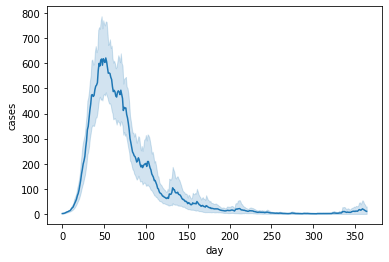

In [101]:
sns.lineplot(x="day", y="cases", data=df)

## Model the New Zealand Population

Roughly based on vaccine numbers from https://covid19.govt.nz/news-and-data/covid-19-data-and-statistics/ as of 2022-02-26.

Let's give people some variation in their inate immunity, even in a totally naive population.

0.06250930886735409


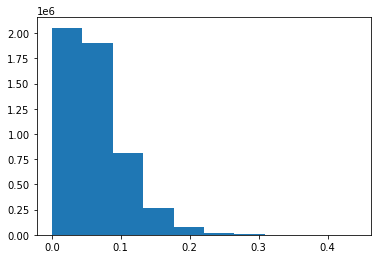

In [57]:
n = 5127200
pop = np.random.beta(2,30,n)
plt.hist(pop)
print(pop.mean())

In [58]:
vax_protection_inf = [0.0, 0.25, 0.33, 0.70]
vax_protection_hos = [0.0, 0.50, 0.70, 0.85]

In [59]:
ped_doses = 232_359
doses = [
    n,
    4_017_924 + ped_doses,
    3_956_862,
    2_248_153,
]


print("\nd=0")
print(pop.mean(), pop.std(), pop.min(), pop.max())

std=0.05


d=1
vaxed = np.random.choice(n, size=doses[d])
protection = np.random.normal(vax_protection_inf[d], std, size=doses[d])
pop[vaxed] += protection
pop = pop.clip(0,1)
print(f"\nd={d}")
print(len(vaxed))
print(protection.mean(), protection.std())
print(pop.mean(), pop.std(), pop.min(), pop.max())


d=2
vaxed = np.random.choice(vaxed, size=doses[d])
pop[vaxed] += np.random.normal(vax_protection_inf[d]-vax_protection_inf[d-1], std, size=doses[d])
pop = pop.clip(0,1)
print(f"\nd={d}")
print(len(vaxed))
print(protection.mean(), protection.std())
print(pop.mean(), pop.std(), pop.min(), pop.max())

d=3
vaxed = np.random.choice(vaxed, size=doses[d])
pop[vaxed] += np.random.normal(vax_protection_inf[d]-vax_protection_inf[d-1], std, size=doses[d])
pop = pop.clip(0,1)
print(f"\nd={d}")
print(len(vaxed))
print(protection.mean(), protection.std())
print(pop.mean(), pop.std(), pop.min(), pop.max())

doses = [
    doses[0]-doses[1],
    doses[1]-doses[2],
    doses[2]-doses[3],
    doses[3]
]
print(doses)
print(sum(doses))


d=0
0.06250930886735409 0.04216373879530694 3.703736956020843e-05 0.4414423378100567

d=1
4250283
0.24999755736224583 0.04997603537219009
0.20341082622359846 0.13621284208335757 3.703736956020843e-05 0.751389924567571

d=2
3956862
0.24999755736224583 0.04997603537219009
0.23499764136035928 0.16721121001667957 3.703736956020843e-05 0.8416941791232149

d=3
2248153
0.24999755736224583 0.04997603537219009
0.3239492559347435 0.2855012307894706 3.703736956020843e-05 1.0
[876917, 293421, 1708709, 2248153]
5127200


(array([1857671.,  394722.,  467377.,  734656.,  360358.,  123855.,
         275018.,  490809.,  326209.,   96525.]),
 array([3.70373696e-05, 1.00033334e-01, 2.00029630e-01, 3.00025926e-01,
        4.00022222e-01, 5.00018519e-01, 6.00014815e-01, 7.00011111e-01,
        8.00007407e-01, 9.00003704e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

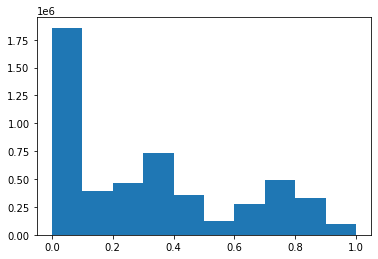

In [60]:
plt.hist(pop)

100%|██████████| 365/365 [2:35:24<00:00, 25.55s/it]  


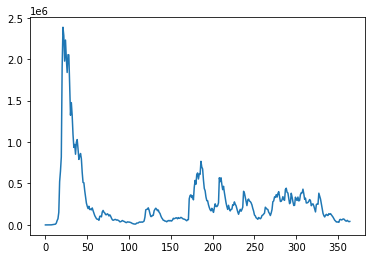

In [61]:
cases = np.zeros(n)
cases[0] = 10

n_cases = []
for i in tqdm(range(365)):
    cases = spread(cases, pop, n=n, r0=15)
    cases, pop = recover(cases, pop, waning_immunity=0.9985)
    n_cases.append(sum(cases>0))

plt.plot(n_cases)

## Distributions

(array([  4.,  25.,  59.,  95., 132., 178., 176., 158., 130.,  43.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

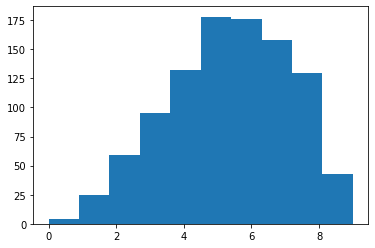

In [625]:
plt.hist(x=(np.random.beta(3,2,1000)*10).astype(int))

In [ ]:
import seaborn as sns
z = np.random.lognormal(1.5, 1, 1000) / np.exp(1.5 + 1/2)
print(z.mean(), np.exp(0 + 1/2))
sns.kdeplot(z)

In [618]:
def mode_of_beta(a,b):
    if a < 1 and b < 1:
        return (0,1)
    if a <=1 and b > 1:
        return 0
    if a > 1 and b <= 1:
        return 1
    return (a-1) / (a+b-2)

In [619]:
mode_of_beta(10,2)

0.9

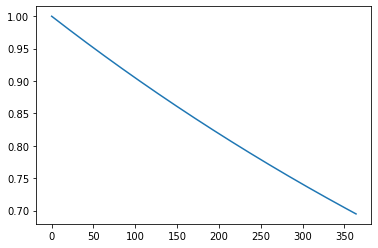

In [65]:
n=365
x=np.ones(n)
for i in range(1,n):
    x[i] = x[i-1]*0.999
plt.plot(x)